<a href="https://colab.research.google.com/github/GHC-av/DL_project/blob/main/DL_project_LoadModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning - Final Project
## Load Models

In [ ]:
import cv2
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import keras
from keras.models import Sequential
from keras import layers
from keras import models
import sklearn
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from keras.applications import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from keras.callbacks import CSVLogger

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Obtain your data and find a way to load it into Python and (3) detailed description of the dataset
e.g. size, number of samples, histograms, etc.

The images were downloaded on my local disk. The X-ray images are stored in a folder called "chest_xray", the folder has 3 subfolders: train, test. Each of these 2 folders has 2 subfolders: Pneumonia, Normal. The images are located in here.

*Note*: in the [original dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/notebooks), the validation set is very small (only 16 examples). For this reason I decided to use this alternative [version](https://www.kaggle.com/tolgadincer/labeled-chest-xray-images) where the validation data set have been merged with the train set. I will simply specify the validation holdout set during the model training.

First, we load the images

In [ ]:
labels = ['NORMAL', 'PNEUMONIA'] # I want 1 = Pneumonia
img_size = 150
def get_im(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label) # 0 or 1
        for img in os.listdir(path):
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            #cv2.IMREAD_COLOR try this instead of cv2.IMREAD_GRAYSCALE
            resized_arr = cv2.resize(img_arr, (img_size, img_size))
            data.append([resized_arr, class_num])
    return np.array(data)

In [ ]:
train_path = "/content/drive/My Drive/chest_xray/train/"
test_path =  "/content/drive/My Drive/chest_xray/test/"

In [ ]:
train = get_im(train_path)
test = get_im(test_path)

In [ ]:
type(train)

numpy.ndarray

In [ ]:
train.shape

(5249, 2)

In [ ]:
print( f'There are {len(train)} images in our train dataset')
print( f'There are {len(test)} images in our train dataset')

There are 5249 images in our train dataset
There are 624 images in our train dataset


The number of Pneumonia images is three times the number of images labelled as normal. This might be a sign of an imbalanced data set.

Labelling:
- 0 = Normal
- 1 = Pneumonia

In [ ]:
print(f"binary value {train[0][1]} refers to {labels[train[0][1]]}")
print(f"binary value {train[-1][1]} refers to {labels[train[-1][1]]}")

binary value 0 refers to NORMAL
binary value 1 refers to PNEUMONIA


Normal images count in training set: 1366
Pneumonia images count in training set: 3883


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


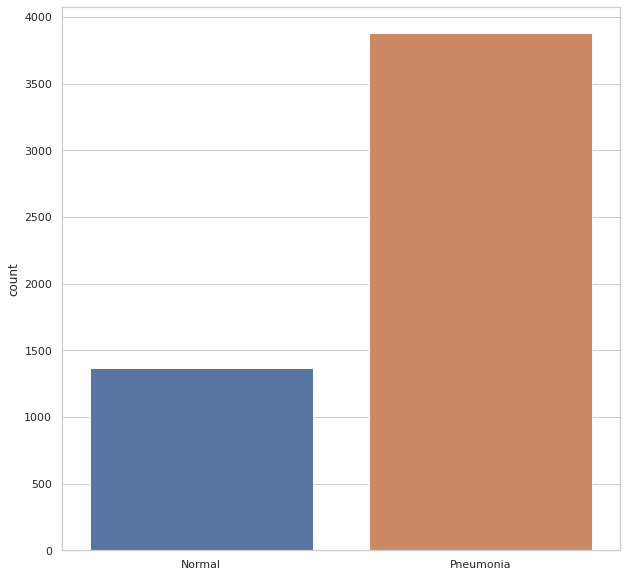

In [ ]:
l = []
count_pneumonia = 0
count_normal=0

for i in train:
    if(i[1] == 1):
        count_pneumonia +=1
        l.append("Pneumonia")
    else:
        l.append("Normal")
        count_normal +=1

print("Normal images count in training set: " + str(count_normal))
print("Pneumonia images count in training set: " + str(count_pneumonia))

sns.countplot(l)  

In [ ]:
# get count of normal and pneumonia example to calculate the weights (imbalanced dataset)
normal_path= os.path.join(train_path, "NORMAL")
norm_img = os.listdir(normal_path)
norm_count = len(norm_img)

pneu_path= os.path.join(train_path, "PNEUMONIA")
pneu_img = os.listdir(pneu_path)
pneu_count = len(pneu_img)

tot_train_img = norm_count + pneu_count

In [ ]:
pneu_weight = (1 / pneu_count)*(tot_train_img)/2.0
norm_weight = (1 / norm_count)*(tot_train_img)/2.0

# Order of the classes, mapped to the label indices, is alphanumeric
class_weight = {0: norm_weight, 1: pneu_weight}

print('Weight for class pneumonia: {:.2f}'.format(pneu_weight)) #0.68
print('Weight for class normal: {:.2f}'.format(norm_weight)) #1.92

Weight for class pneumonia: 0.68
Weight for class normal: 1.92


As a consequence of the way we read the files, normal images are in the first rows of our train data set while Pneumonia images are at the bottom.

Text(0.5, 1.0, 'PNEUMONIA')

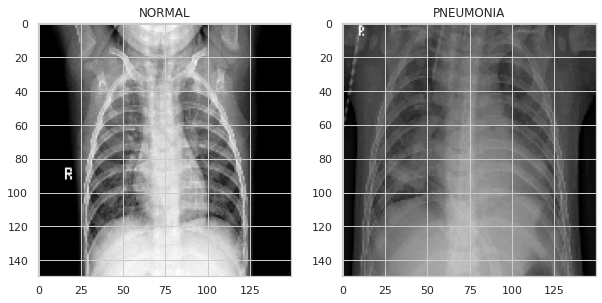

In [ ]:
# Plot the first and the last image of the train set.
f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(train[0][0], cmap='Greys_r')
a1.set_title(labels[train[0][1]])

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(train[-1][0], cmap='Greys_r')
a2.set_title(labels[train[-1][1]])

## 2. Process your data with a simple baseline model

For example, if your project involves classification a natural baseline model would be logistic regression.

Split the train and test set in x (image) and y (label)

In [ ]:
x_train = []
y_train = []

x_test = []
y_test = []

for i in train:
    image = i[0]
    lab = i[1]
    x_train.append(image)
    y_train.append(lab)

for i in test:
    image = i[0]
    lab = i[1]
    x_test.append(image)
    y_test.append(lab)

Normalize the images and reshape them so that we can feed them to our model

In [ ]:
x_train = np.array(x_train)/255
x_test = np.array(x_test)/255

In [ ]:
x_train = x_train.reshape(-1, img_size*img_size)
y_train = np.array(y_train)

x_test = x_test.reshape(-1, img_size*img_size)
y_test = np.array(y_test)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(5249, 22500)
(5249,)
(624, 22500)
(624,)


In [ ]:
model_base = tf.keras.models.load_model('/content/drive/My Drive/chest_xray/modelBASE.h5')

## 4. Results from the baseline model
e.g., classification accuracy.

In [ ]:
loss, acc, prec, rec = model_base.evaluate(x_test, y_test)
f1 = 2/((1/prec) + (1/rec))
print("Loss of the model is - %.3f" % loss)
print("Accuracy of the model is - %.3f" % acc)
print("Precision of the model is - %.3f" % prec)
print("Recall of the model is - %.3f" % rec)
print("F1 score of the model is - %.3f" % f1)

20/20 [==============================] - 0s 2ms/step - loss: 1.3115 - accuracy: 0.7869 - precision: 0.7485 - recall: 0.9923    
Loss of the model is - 1.311
Accuracy of the model is - 0.787
Precision of the model is - 0.749
Recall of the model is - 0.992
F1 score of the model is - 0.853


In [ ]:
BASE_log_data = pd.read_csv('/content/drive/My Drive/chest_xray/Base_training.log', sep=',', engine='python')

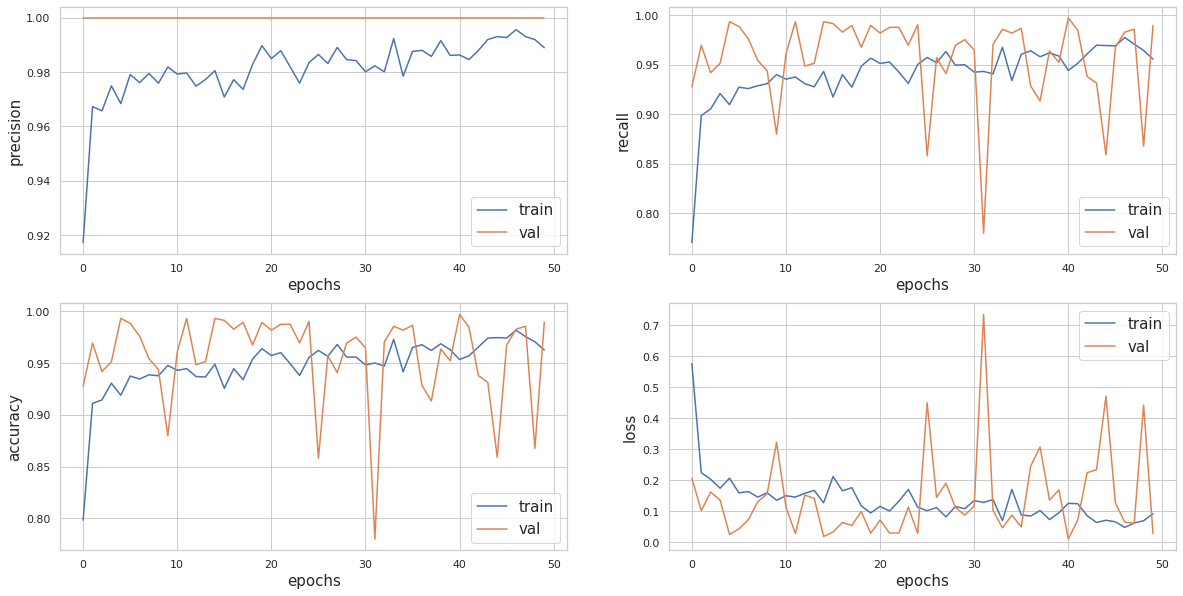

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(BASE_log_data[met]) # train  history_base.history
    ax[i].plot(BASE_log_data['val_' + met]) # validation
    #ax[i].set_ylim([0,1.05])
    #sns.set(font_scale=1)
    #ax[i].set_title('Model {}'.format(met))
    sns.set_style("whitegrid")
    ax[i].set_xlabel('epochs', fontsize = 15)
    ax[i].set_ylabel(met, fontsize = 15)
    ax[i].legend(['train', 'val'], fontsize = 15)

In [ ]:
# Get predictions

preds_base = model_base.predict(x_test)
#preds_base[preds_base <= 0.5] = 0
#preds_base[preds_base > 0.5] = 1

print(y_test.shape)
print(preds_base.shape)

(624,)
(624, 1)


In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(8,6))
  #sns.heatmap(cm, annot=True, fmt="g")
  sns.set(font_scale=2.0)
  plot_confusion_matrix(cm,figsize=(8,6))
  plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
  plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
  #plt.title('Confusion matrix with threshold {:.2f}'.format(p))
  plt.ylabel('Actual label', fontsize = 16)
  plt.xlabel('Predicted label', fontsize = 16)

  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])
  print('Total Pneumonia images: ', np.sum(cm[1]))

True Negatives:  104
False Positives:  130
False Negatives:  3
True Positives:  387
Total Pneumonia images:  390


<Figure size 576x432 with 0 Axes>

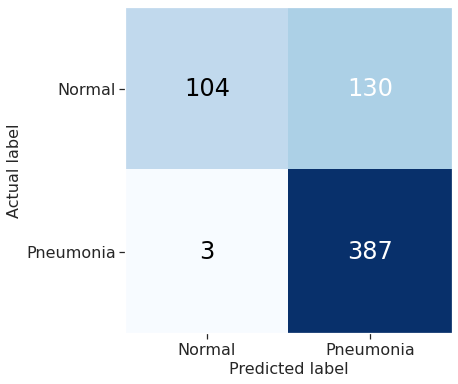

In [ ]:
plot_cm(y_test, preds_base)

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
  model_auc = sklearn.metrics.roc_auc_score(labels, predictions)
  no_pred = np.zeros(len(labels))
  no_fp, no_tp, _ = sklearn.metrics.roc_curve(labels, no_pred)
  sns.set(font_scale=1)
  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.plot(100*no_fp, 100*no_tp, linewidth=2, linestyle='--', label="Random",**kwargs)
  plt.xlabel('False positives [%]', fontsize = 20)
  plt.ylabel('True positives [%]', fontsize = 20)
  #plt.xlim([-0.5,20])
  plt.xlim([0,100.5])
  plt.ylim([0,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
  plt.legend(loc='lower right', fontsize = 20)
  sns.set_style("whitegrid")
  

  print('Model: ROC AUC=%.3f' % (model_auc))

Model: ROC AUC=0.946


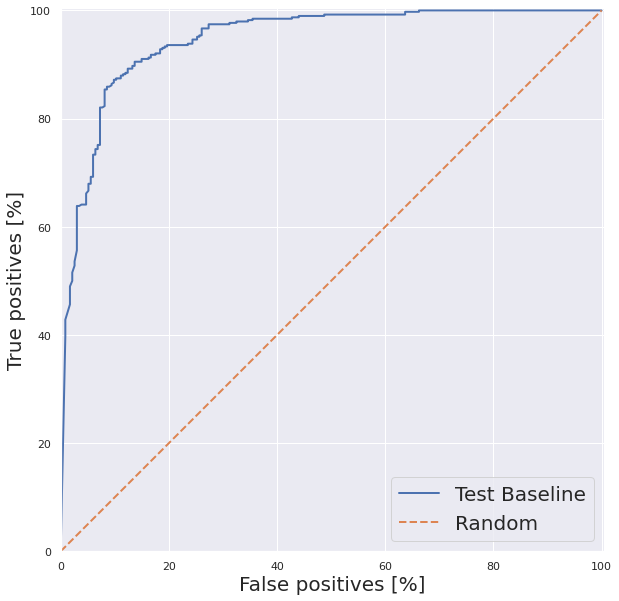

In [ ]:
mpl.rcParams['figure.figsize'] = (10, 10)
#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_roc("Test Baseline", y_test, preds_base)


## 5. CNN model

Next, I will try 2 different methods:

- Implement a convolutional neural network from scratch. The CNN will draw inspiration from the paper An Efficient Deep Learning Approach to Pneumonia Classification in Healthcare
- Implement a CNN based on DenseNet architecture. This is a similar approach as used in the CheXNet from Stanford.

In addition, Since the data set seems imbalanced, I'll assign some weights to the classes and use them in the loss function.

In [ ]:
model_CNN = tf.keras.models.load_model('/content/drive/My Drive/chest_xray/modelCNN.h5')

In [ ]:
CNN_log_data = pd.read_csv('/content/drive/My Drive/chest_xray/CNN_training.log', sep=',', engine='python')

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
img_size = 150
batch_size = 32

test_set = test_datagen.flow_from_directory(
    test_path,
    target_size = (img_size, img_size),
    color_mode="rgb", # "grayscale"
    class_mode = 'binary',
    batch_size = batch_size,
    shuffle = False # I want the same order as y_test
    )

Found 624 images belonging to 2 classes.


In [ ]:
test_set.reset()
loss, acc, prec, rec = model_CNN.evaluate(test_set)

f1 = 2/((1/prec) + (1/rec))
print("Loss of the model is - %.3f" % loss)
print("Accuracy of the model is - %.3f" % acc)
print("Precision of the model is - %.3f" % prec)
print("Recall of the model is - %.3f" % rec)
print("F1 score of the model is - %.3f" % f1)

20/20 [==============================] - 13s 651ms/step - loss: 0.1579 - accuracy: 0.9567 - precision: 0.9595 - recall: 0.9718
Loss of the model is - 0.158
Accuracy of the model is - 0.957
Precision of the model is - 0.959
Recall of the model is - 0.972
F1 score of the model is - 0.966


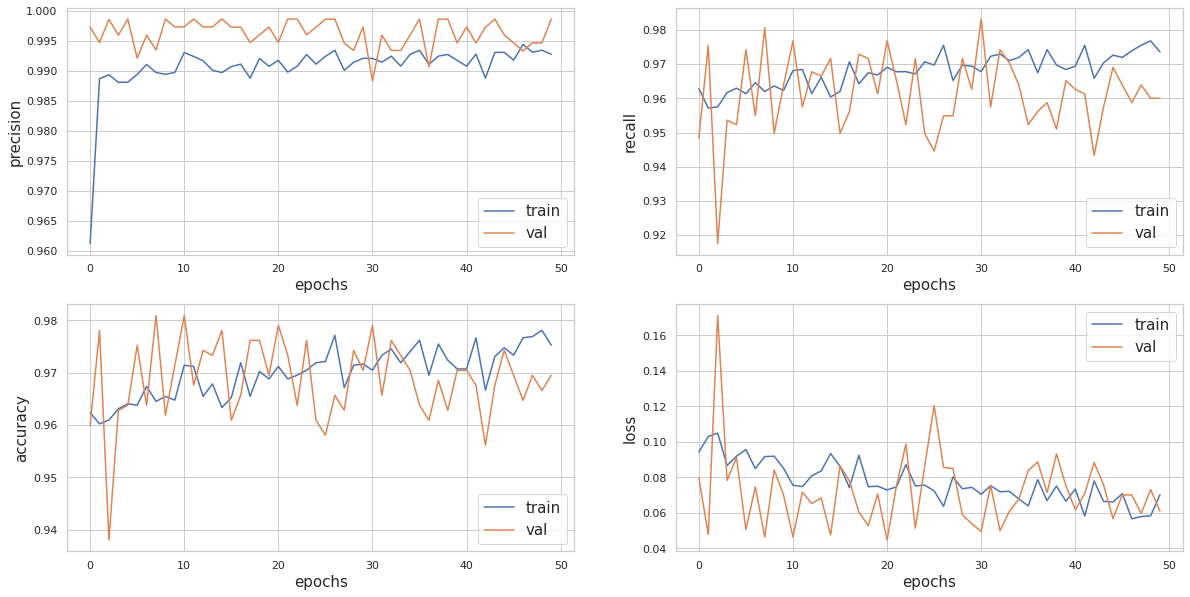

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(CNN_log_data[met]) # train
    ax[i].plot(CNN_log_data['val_' + met]) # validation
    #ax[i].set_title('Model {}'.format(met))
    sns.set_style("whitegrid")
    ax[i].set_xlabel('epochs', fontsize = 15)
    ax[i].set_ylabel(met, fontsize = 15)
    ax[i].legend(['train', 'val'], fontsize = 15)

In [ ]:
# Get predictions
test_set.reset()
preds_CNN = model_CNN.predict(test_set)
preds_CNN.shape

(624, 1)

True Negatives:  218
False Positives:  16
False Negatives:  11
True Positives:  379
Total Pneumonia images:  390


<Figure size 576x432 with 0 Axes>

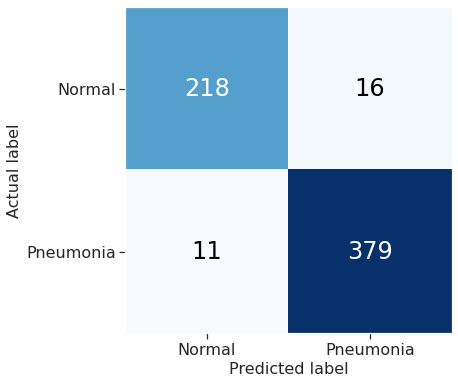

In [ ]:
plot_cm(y_test, preds_CNN)

Model: ROC AUC=0.987


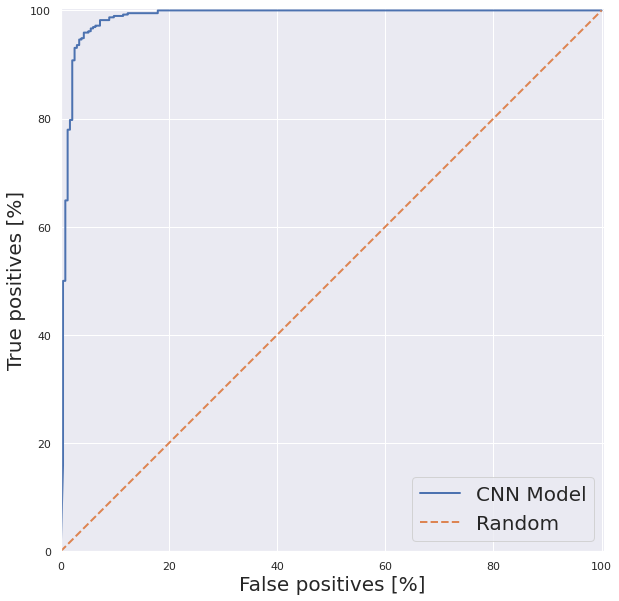

In [ ]:
plot_roc("CNN Model", y_test, preds_CNN)

 ## DenseNet

In [ ]:
model_DN = tf.keras.models.load_model('/content/drive/My Drive/chest_xray/modelDN.h5')

In [ ]:
DN_log_data = pd.read_csv('/content/drive/My Drive/chest_xray/DN_training.log', sep=',', engine='python')

In [ ]:
test_set.reset()
loss, acc, prec, rec = model_DN.evaluate(test_set)

f1 = 2/((1/prec) + (1/rec))
print("Loss of the model is - %.3f" % loss)
print("Accuracy of the model is - %.3f" % acc)
print("Precision of the model is - %.3f" % prec)
print("Recall of the model is - %.3f" % rec)
print("F1 score of the model is - %.3f" % f1)

20/20 [==============================] - 40s 2s/step - loss: 0.1203 - accuracy: 0.9647 - precision: 0.9600 - recall: 0.9846
Loss of the model is - 0.120
Accuracy of the model is - 0.965
Precision of the model is - 0.960
Recall of the model is - 0.985
F1 score of the model is - 0.972


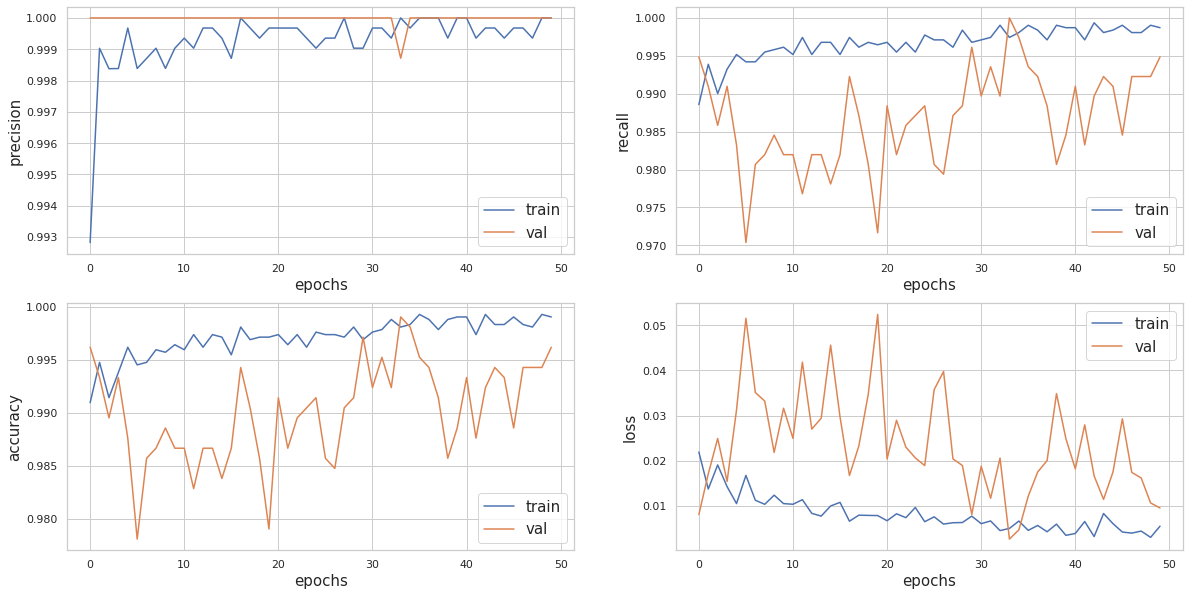

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(DN_log_data[met]) # train
    ax[i].plot(DN_log_data['val_' + met]) # validation
    #ax[i].set_title('Model {}'.format(met))
    sns.set_style("whitegrid")
    ax[i].set_xlabel('epochs', fontsize = 15)
    ax[i].set_ylabel(met, fontsize = 15)
    ax[i].legend(['train', 'val'], fontsize = 15)

In [ ]:
# Get predictions
test_set.reset()
preds_DN = model_DN.predict(test_set)
preds_DN.shape

(624, 1)

True Negatives:  218
False Positives:  16
False Negatives:  6
True Positives:  384
Total Pneumonia images:  390


<Figure size 576x432 with 0 Axes>

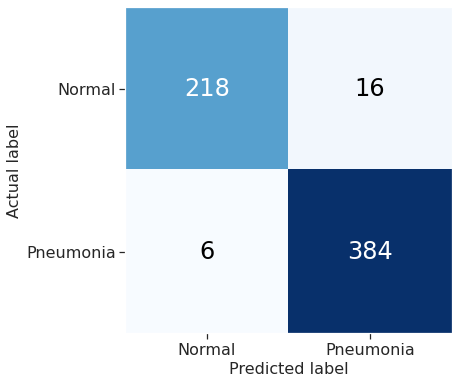

In [ ]:
plot_cm(y_test, preds_DN)

Model: ROC AUC=0.996


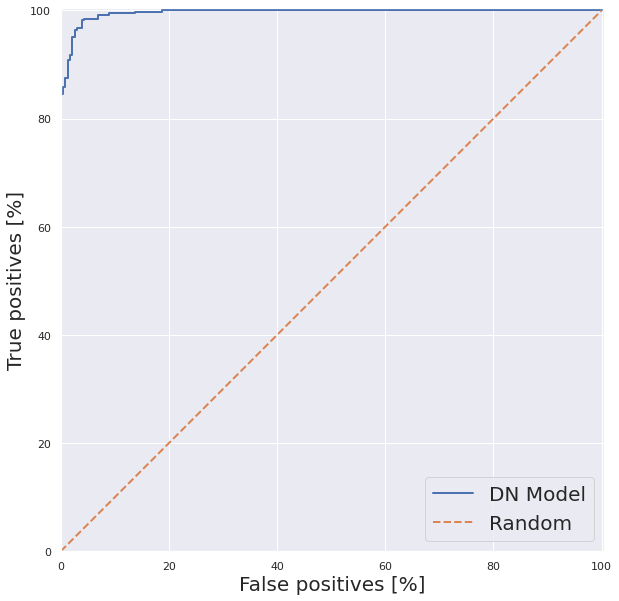

In [ ]:
plot_roc("DN Model", y_test, preds_DN)

conv2d (3, 3, 3, 32)
32


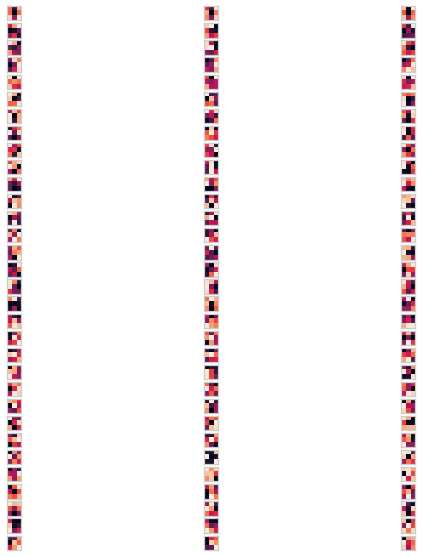

conv2d_1 (3, 3, 32, 64)
64


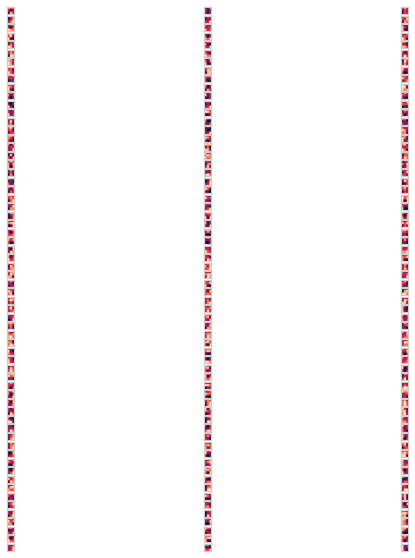

conv2d_2 (3, 3, 64, 128)
128


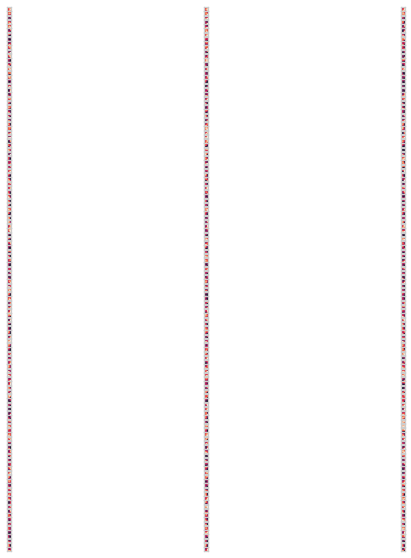

conv2d_3 (3, 3, 128, 128)
128


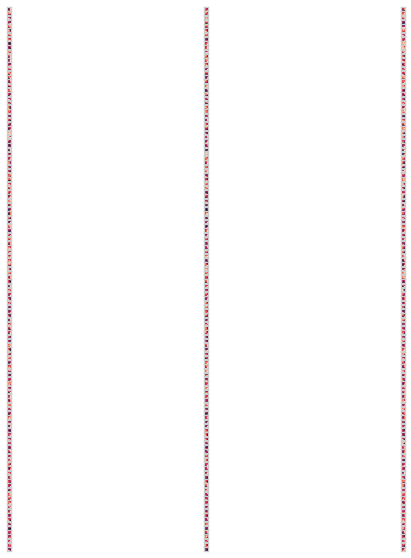

In [ ]:
#Iterate thru all the layers of the model
for layer in model_CNN.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        
        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)
        print(layer.name, filters.shape)
        print(filters.shape[3])
        filter_cnt=1
        
        #plotting all the filters
        for i in range(filters.shape[3]):
            #get the filters
            filt=filters[:,:,:, i]
            #plotting each of the channel, color image RGB channels
            for j in range(filters.shape[0]):
                ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        plt.show()

(1, 74, 74, 32)
(1, 72, 72, 64)
(1, 36, 36, 64)
(1, 34, 34, 128)
(1, 17, 17, 128)
(1, 15, 15, 128)
(1, 7, 7, 128)
(1, 6272)
(1, 6272)
(1, 512)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


(1, 1)


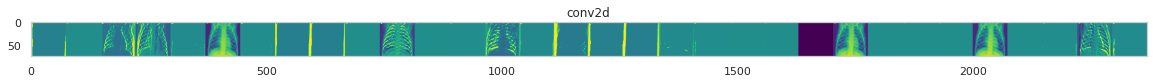

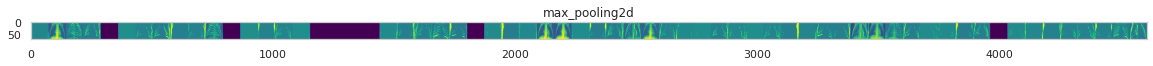

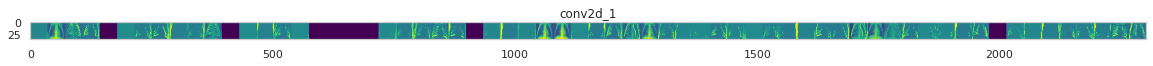

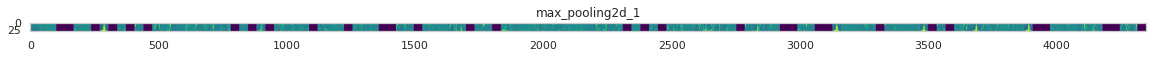

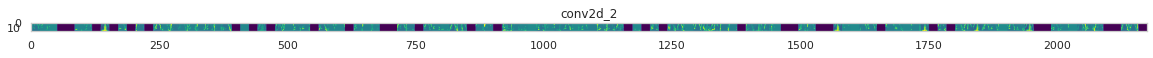

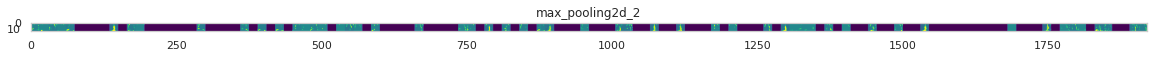

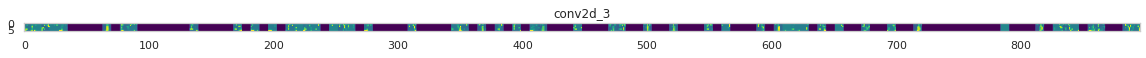

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

img_path='/content/drive/My Drive/chest_xray/test/PNEUMONIA/VIRUS-8574414-0001.jpeg' #pneumonia
# Define a new Model, Input= image 
# Output= intermediate representations for all layers in the  
# previous model after the first.
successive_outputs = [layer.output for layer in model_CNN.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model_CNN.input, outputs = successive_outputs)
#Load the input image
img = load_img(img_path, target_size=(150, 150))
# Convert ht image to Array of dimension (150,150,3)
x   = img_to_array(img)                           
x   = x.reshape((1,) + x.shape)
# Rescale by 1/255
x /= 255.0
# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model_CNN.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )